#### Loading the Required Libraries

In [1]:
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import geopy.distance
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
plt.rcParams['figure.figsize'] = [10,6]
import warnings 
warnings.filterwarnings('ignore')

#### Loading the dataset

In [2]:
#Importing the dataset.
uber_df = pd.read_csv('uber.csv')

In [3]:
# Display the first 5 records.
uber_df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
#Display the info about the dataframe.
uber_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [5]:
# Number of rows and columns.
uber_df.shape

(200000, 9)

In [6]:
# Some Statistical data.
uber_df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


#### Pre-processing and Transformation

In [7]:
# Dropping the first two columns as it is not required.
uber_df.drop(['Unnamed: 0','key'], axis=1, inplace=True)

In [8]:
# Assigning the target and feature variables.
target = 'fare_amount'
features = [i for i in uber_df.columns if i not in [target]]

print('\n\033[1mInference:\033[0m The Dataset consists of {} features & {} samples.'.format(uber_df.shape[1], uber_df.shape[0]))


Inference: The Dataset consists of 7 features & 200000 samples.


In [9]:
# To check the count of null values.
uber_df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [10]:
# Drop the null values.
uber_df.dropna(inplace=True)

In [11]:
# To check for duplicates.
uber_df.duplicated().sum()

0

In [12]:
# To check the count of null values after the rows are dropped.
uber_df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [13]:
#Convert pickup_datetime to datetime object.
uber_df.pickup_datetime=pd.to_datetime(uber_df.pickup_datetime)

# Extract the year, month, weekday, and hour from the 'pickup_datetime' column.
uber_df['year'] = uber_df.pickup_datetime.dt.year
uber_df['month'] = uber_df.pickup_datetime.dt.month
uber_df['day'] = uber_df.pickup_datetime.dt.day
uber_df['dayofweek'] = uber_df.pickup_datetime.dt.dayofweek
uber_df['hour'] = uber_df.pickup_datetime.dt.hour

In [14]:
# Dropping unnecessary column.
uber_df.drop(['pickup_datetime'], axis=1, inplace=True)

In [15]:
# Filters out any latitudes and longitudes that are outside the valid range -90 to 90 and -180 to 180.
uber_df = uber_df[(uber_df.pickup_latitude<90) & (uber_df.dropoff_latitude<90) &
        (uber_df.pickup_latitude>-90) & (uber_df.dropoff_latitude>-90) &
        (uber_df.pickup_longitude<180) & (uber_df.dropoff_longitude<180) &
        (uber_df.pickup_longitude>-180) & (uber_df.dropoff_longitude>-180)]

In [16]:
# Function to calculate the travel distance from the longitudes and latitudes.
from math import *
    
def distance_formula(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []
    
    for pos in range (len(longitude1)):
        lon1, lan1, lon2, lan2 = map(radians, [longitude1[pos], latitude1[pos], longitude2[pos], latitude2[pos]])
        dist_lon = lon2 - lon1
        dist_lan = lan2 - lan1
        
        a = sin(dist_lan/2)**2 + cos(lan1) * cos(lan2) * sin(dist_lon/2)**2
        
        # Radius of the earth = 6371
        c = 2 * asin(sqrt(a)) * 6371 
        travel_dist.append(c)
            
    return  travel_dist

In [17]:
uber_df['dist_travel_km'] = distance_formula(uber_df.pickup_longitude.to_numpy(), uber_df.pickup_latitude.to_numpy(), uber_df.dropoff_longitude.to_numpy(), uber_df.dropoff_latitude.to_numpy())

In [18]:
# Display the first five records.
uber_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayofweek,hour,dist_travel_km
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,3,19,1.683323
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,4,20,2.457590
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,0,21,5.036377
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,4,8,1.661683
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,3,17,4.475450


#### Exploratory Data Analysis

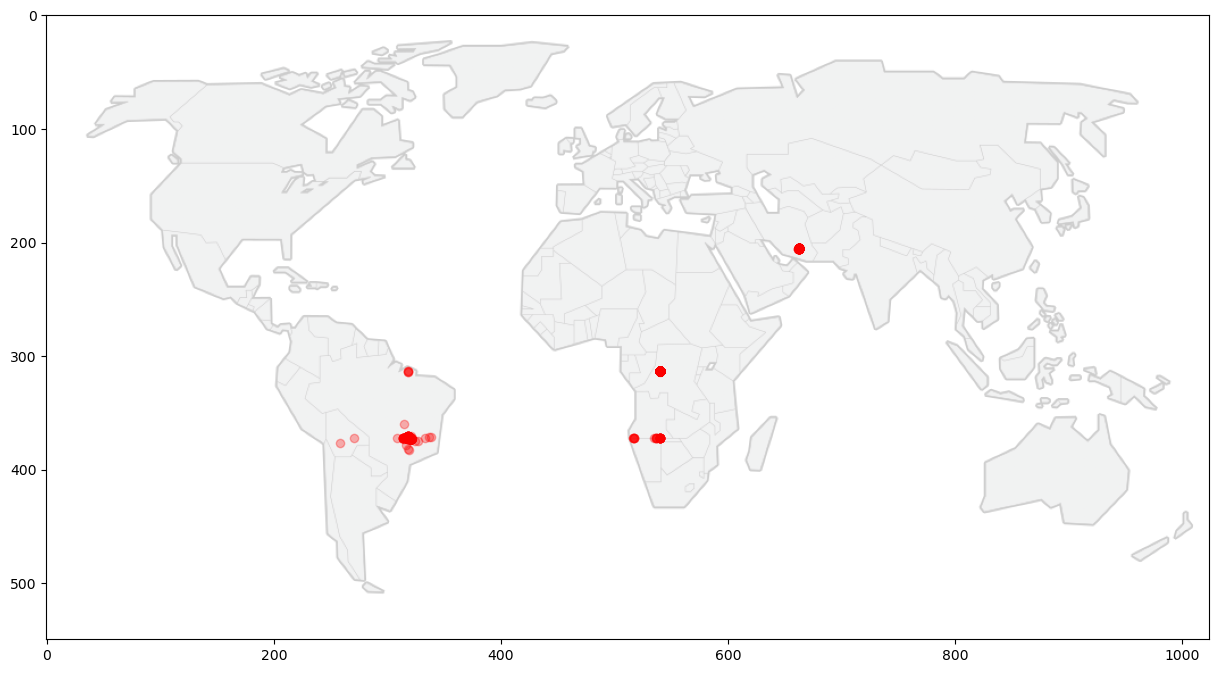

In [19]:
# Plotting the pickup locations on a map.
plt.figure(figsize=[15,10])
a=plt.imread('https://raw.githubusercontent.com/Masterx-AI/Project_Uber_Fare_Prediction/main/wm.png')
plt.imshow(a, alpha=0.2)
plt.scatter( (uber_df.pickup_longitude+180)*3,(uber_df.pickup_latitude+215)*1.45555555,alpha=0.3, color='red')
plt.show()

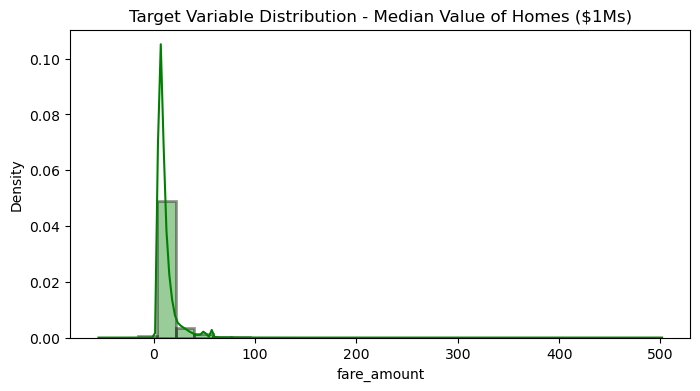

In [20]:
# Distribution of the target variable.
plt.figure(figsize=[8,4])
sns.distplot(uber_df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

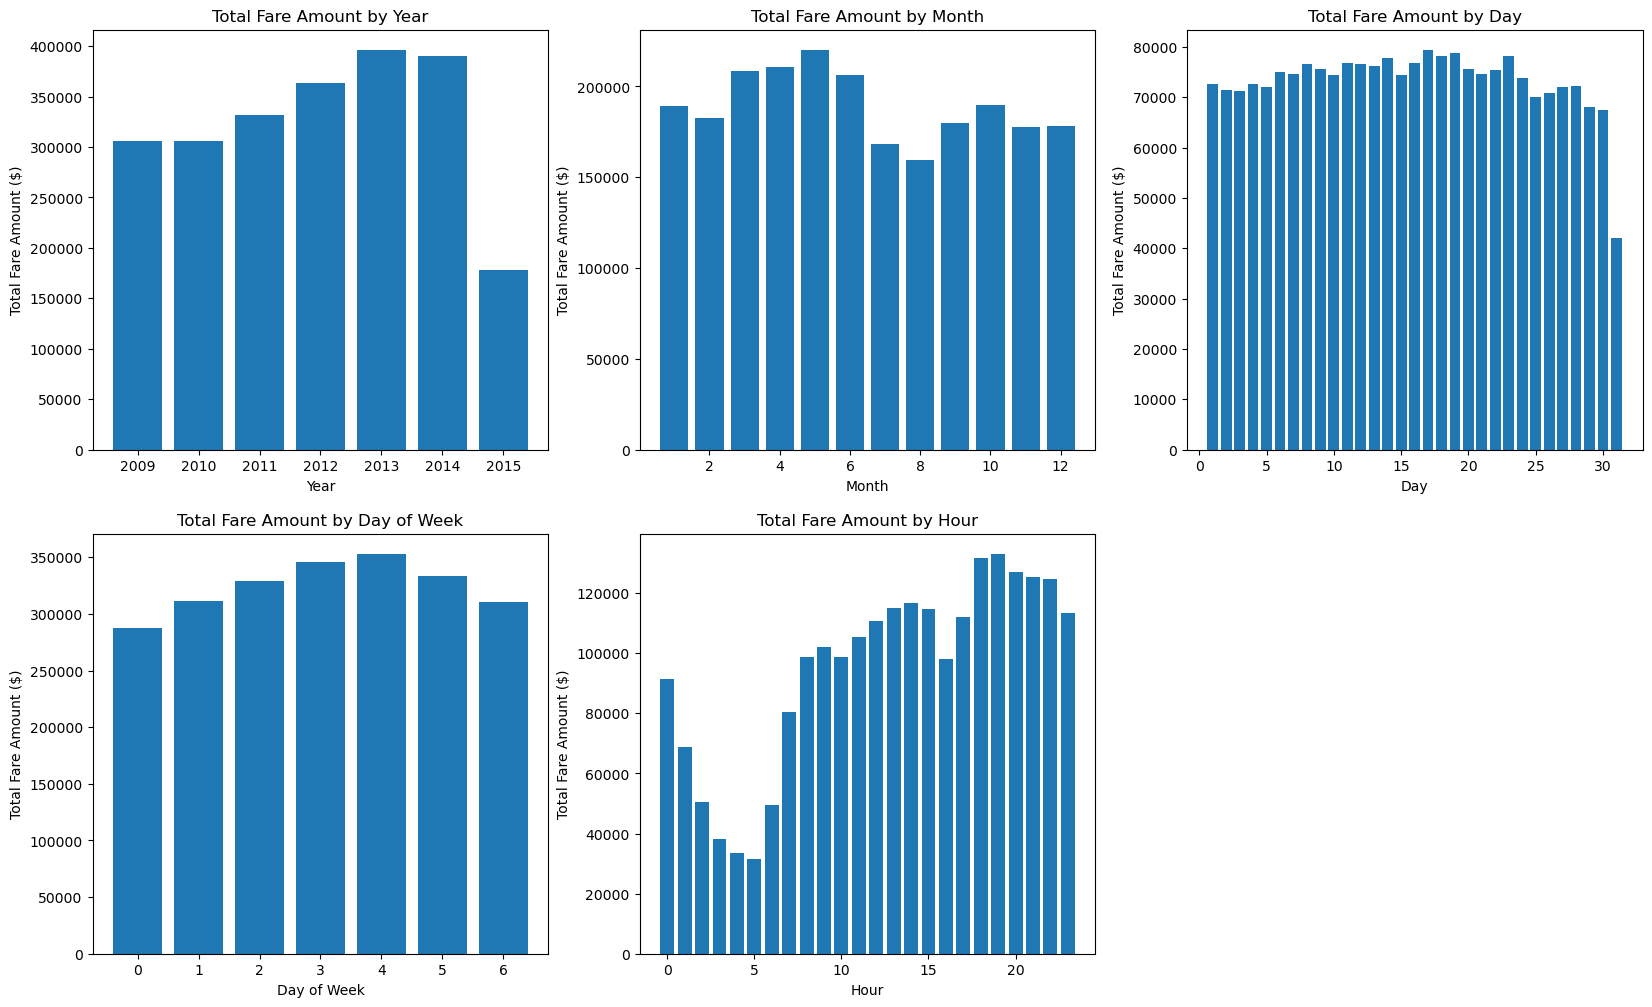

In [21]:
# Group by year, month, day, dayofweek, and hour and calculate the total fare amount.
year_fare = uber_df.groupby("year")["fare_amount"].sum()
month_fare = uber_df.groupby("month")["fare_amount"].sum()
day_fare = uber_df.groupby("day")["fare_amount"].sum()
dayofweek_fare = uber_df.groupby("dayofweek")["fare_amount"].sum()
hour_fare = uber_df.groupby("hour")["fare_amount"].sum()

# Create subplots of total fare amount by year, month, day, dayofweek, and hour.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
axes[0, 0].bar(year_fare.index, year_fare.values)
axes[0, 0].set_title("Total Fare Amount by Year")
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Total Fare Amount ($)")

axes[0, 1].bar(month_fare.index, month_fare.values)
axes[0, 1].set_title("Total Fare Amount by Month")
axes[0, 1].set_xlabel("Month")
axes[0, 1].set_ylabel("Total Fare Amount ($)")

axes[0, 2].bar(day_fare.index, day_fare.values)
axes[0, 2].set_title("Total Fare Amount by Day")
axes[0, 2].set_xlabel("Day")
axes[0, 2].set_ylabel("Total Fare Amount ($)")

axes[1, 0].bar(dayofweek_fare.index, dayofweek_fare.values)
axes[1, 0].set_title("Total Fare Amount by Day of Week")
axes[1, 0].set_xlabel("Day of Week")
axes[1, 0].set_ylabel("Total Fare Amount ($)")

axes[1, 1].bar(hour_fare.index, hour_fare.values)
axes[1, 1].set_title("Total Fare Amount by Hour")
axes[1, 1].set_xlabel("Hour")
axes[1, 1].set_ylabel("Total Fare Amount ($)")

# Hide the last subplot.
axes[1, 2].axis("off")

plt.show()

Text(0.5, 1.0, 'Average fare depending on the distance')

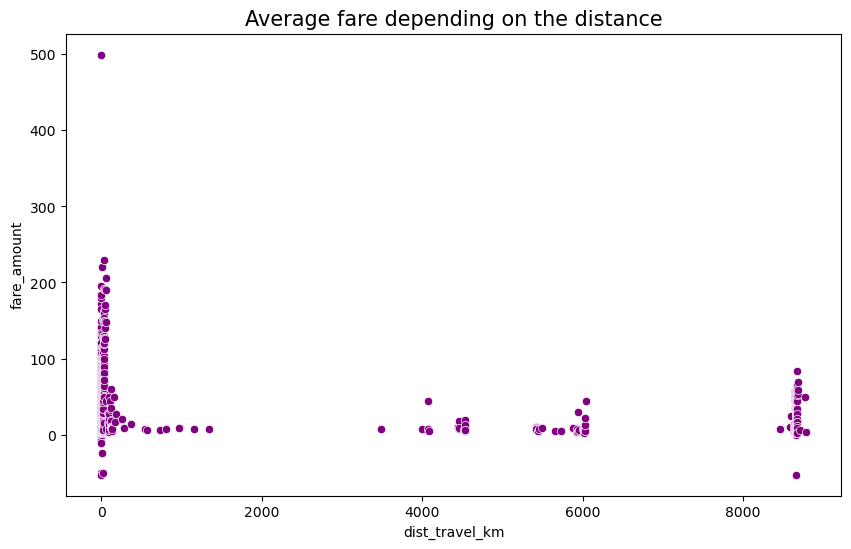

In [22]:
# Average fare depending on the distance.
distance_df=uber_df.groupby(['dist_travel_km'])['fare_amount'].mean().reset_index()
sns.scatterplot(data=distance_df,x='dist_travel_km',y='fare_amount', color='purple').set_title("Average fare depending on the distance",fontsize=15)

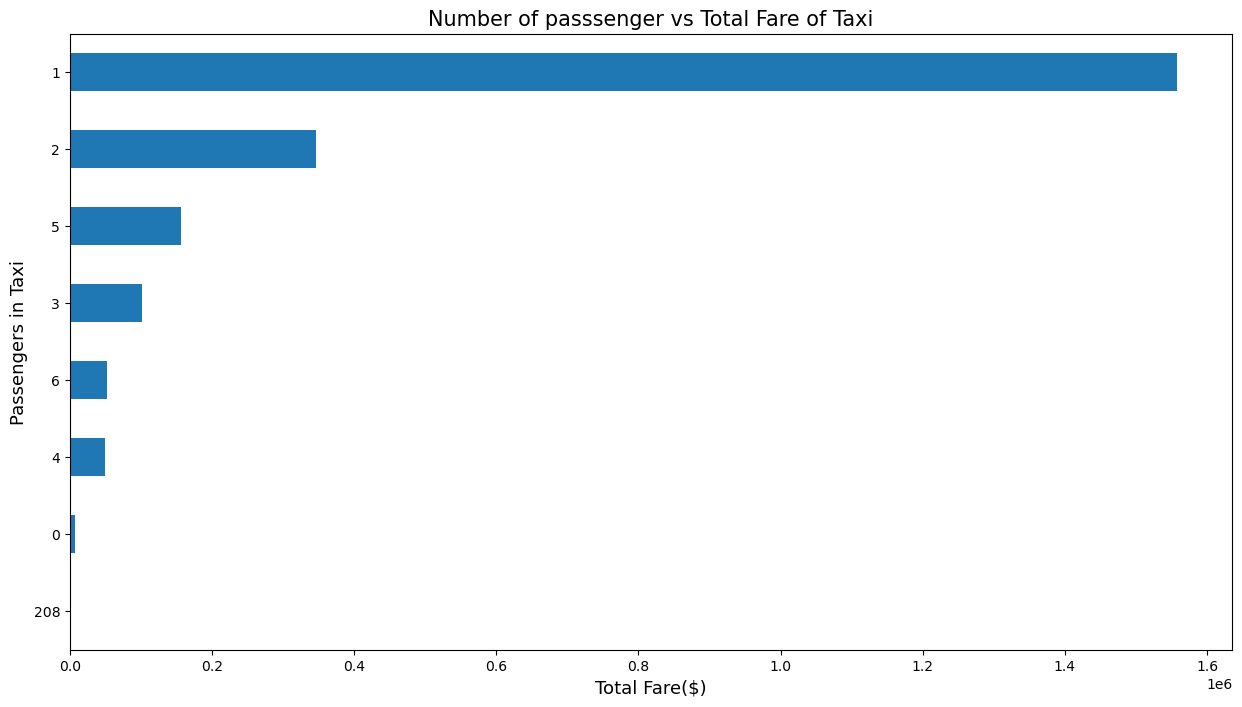

In [23]:
# Passenger Count vs Fare.
plt.figure(figsize=(15,8))
uber_df.groupby("passenger_count")["fare_amount"].sum().sort_values().plot.barh()
plt.xlabel("Total Fare($)",fontsize =13)
plt.ylabel("Passengers in Taxi", fontsize =13)
plt.title("Number of passsenger vs Total Fare of Taxi", fontsize = 15)
plt.show()

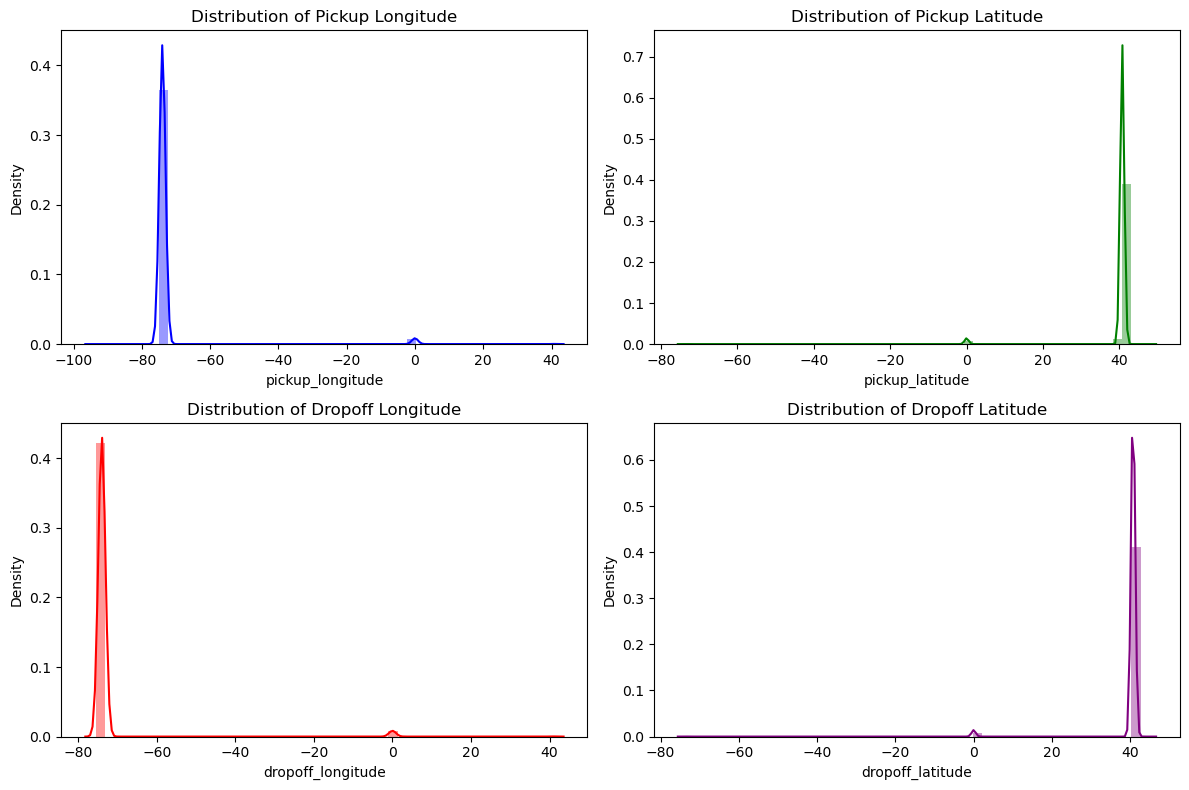

In [24]:
# Create a figure with 2 rows and 2 columns.
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))

# Plot the distribution of pickup_longitude.
sns.distplot(uber_df['pickup_longitude'], ax=axs[0, 0], color='blue')
axs[0, 0].set_title('Distribution of Pickup Longitude')

# Plot the distribution of pickup_latitude.
sns.distplot(uber_df['pickup_latitude'], ax=axs[0, 1], color='green')
axs[0, 1].set_title('Distribution of Pickup Latitude')

# Plot the distribution of dropoff_longitude.
sns.distplot(uber_df['dropoff_longitude'], ax=axs[1, 0], color='red')
axs[1, 0].set_title('Distribution of Dropoff Longitude')

# Plot the distribution of dropoff_latitude.
sns.distplot(uber_df['dropoff_latitude'], ax=axs[1, 1], color='purple')
axs[1, 1].set_title('Distribution of Dropoff Latitude')

# Adjust the spacing between plots.
plt.tight_layout()

# Show the plot.
plt.show()

#### Handling Outliers 

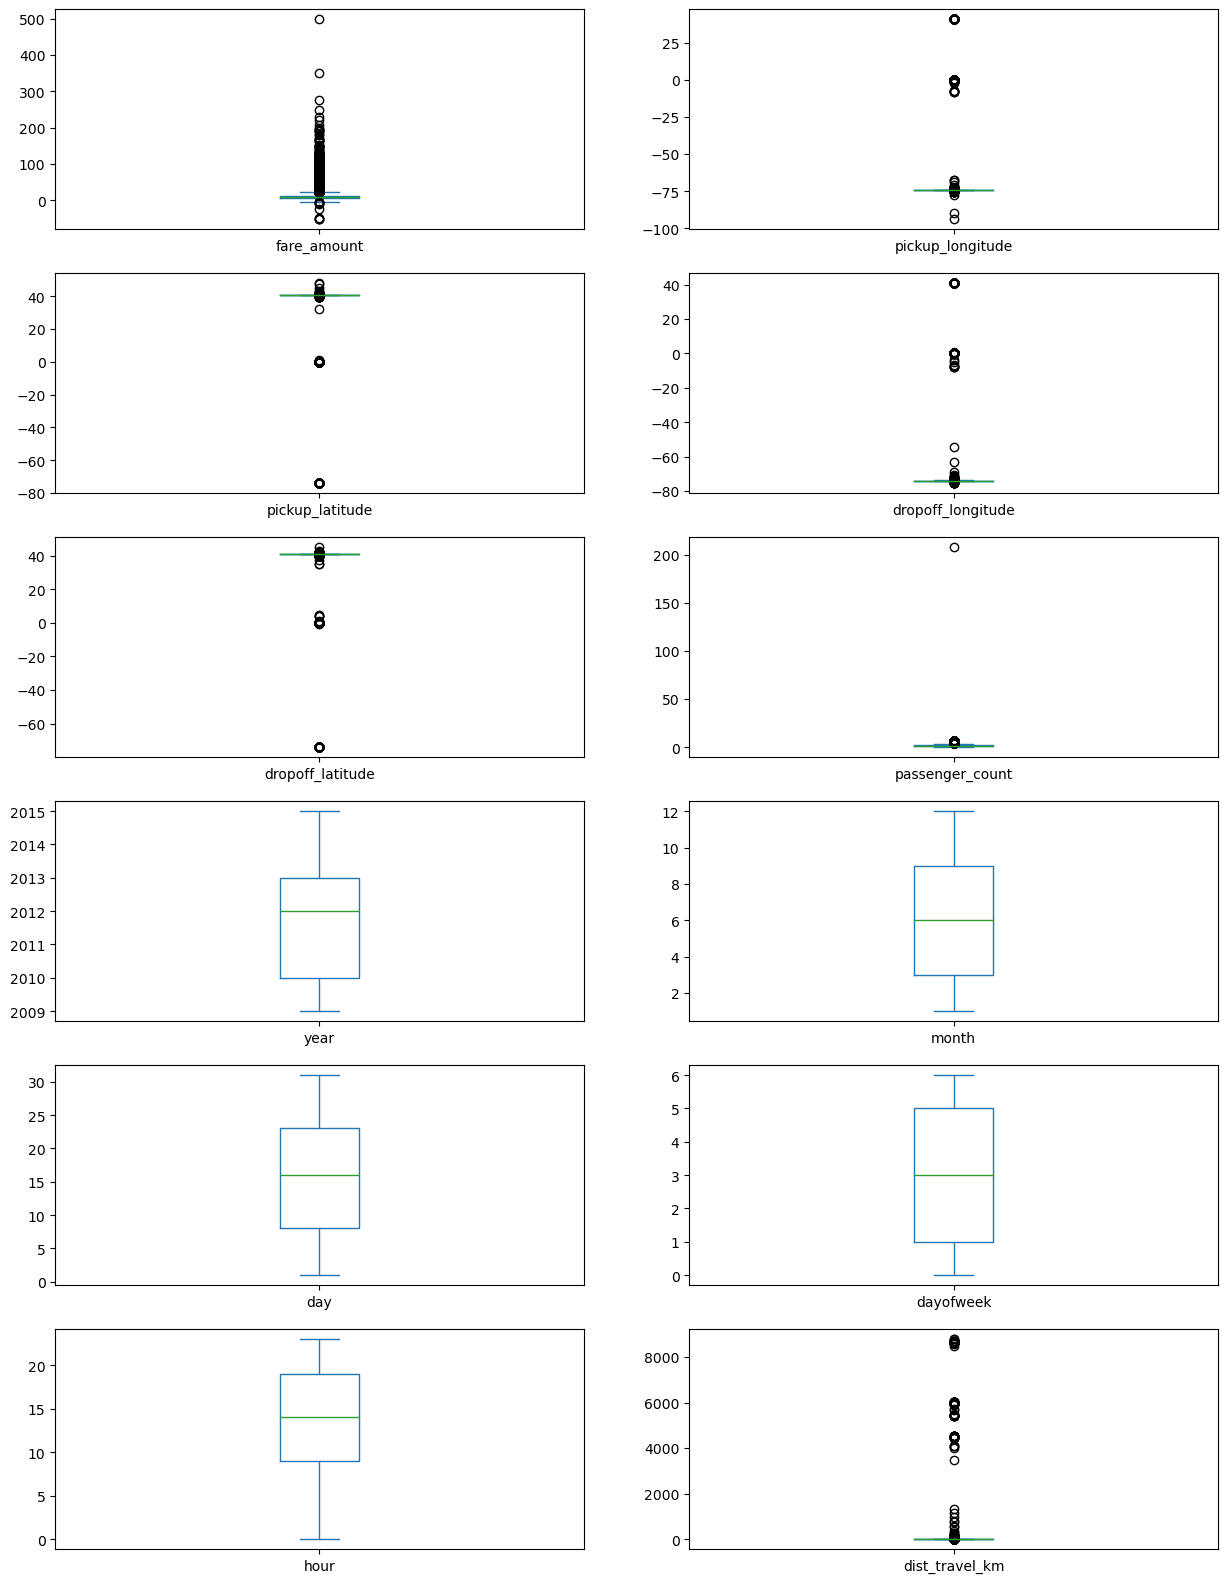

In [25]:
# Boxplot to check for outliers.
uber_df.plot(kind = "box",subplots = True,layout = (6,2),figsize=(15,20)) 
plt.show()

In [26]:
#Using the InterQuartile Range to fill the values.
def remove_outlier(df1 , col):
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    outlier_count = len(df1.loc[(df1[col] < lower_whisker) | (df1[col] > upper_whisker), col])
    uber_df[col] = np.clip(df1[col] , lower_whisker , upper_whisker)
    return df1, outlier_count

def treat_outliers_all(df1 , col_list):
    outlier_counts = {}
    for c in col_list:
        df1, outlier_count = remove_outlier(uber_df , c)
        outlier_counts[c] = outlier_count
    total_outliers_removed = sum(outlier_counts.values())
    return df1

uber_df = treat_outliers_all(uber_df , uber_df.iloc[: , 0::])

In [27]:
uber_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayofweek,hour,dist_travel_km
count,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000
mean,10.080998,-73.978309,40.750194,-73.976192,40.750151,1.514376,2011.742463,6.281783,15.704736,3.048383,13.491562,2.853750
std,5.440187,0.020505,0.025658,0.022879,0.028659,0.876714,1.856438,3.438957,8.687469,1.946960,6.515458,2.223297
min,-3.750000,-74.029429,40.686248,-74.033030,40.682558,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992064,40.734793,-73.991407,40.733823,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.215167
50%,8.500000,-73.981822,40.752592,-73.980092,40.753042,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.120825
75%,12.500000,-73.967154,40.767157,-73.963658,40.768000,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.874779
max,22.250000,-73.929789,40.815702,-73.922034,40.819266,3.500000,2015.000000,12.000000,31.000000,6.000000,23.000000,7.864197


<AxesSubplot:>

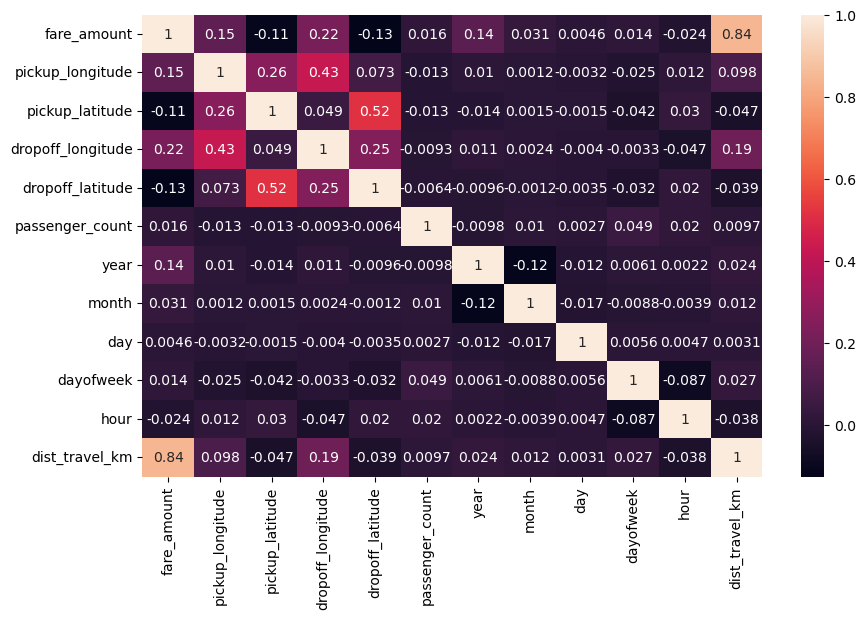

In [28]:
# Plotting heatmap with corelations to identify weakly corelated values.
fig,axis = plt.subplots(figsize = (10,6))
sns.heatmap(uber_df.corr(),annot = True) 

In [29]:
uber_df.to_csv('uber_data_cleaned.csv', index=False)

#### Splitting Dataset for Training and Testing

In [30]:
# Dividing the dataset into feature and target values.
features = uber_df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','hour','day','month','year','dayofweek','dist_travel_km']]
target = uber_df['fare_amount']

In [31]:
x_train, x_test, y_train, y_test = train_test_split(features, target, shuffle = True, test_size = .30, random_state = 44)

In [32]:
print('Shape of training feature:', x_train.shape)
print('Shape of testing feature:', x_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (139990, 11)
Shape of testing feature: (59997, 11)
Shape of training label: (139990,)
Shape of training label: (59997,)


#### Standardization

In [33]:
Scaler = StandardScaler()
Scaler.fit(x_train)

StandardScaler()

In [34]:
x_train = Scaler.transform(x_train)
x_test = Scaler.transform(x_test)

In [35]:
x_test.shape[0]

59997

#### Modeling

##### Random Forest

In [36]:
# Initialize the random forest regressor.
rf_model = RandomForestRegressor(n_estimators=200,random_state=44)

# Train the model on the preprocessed training data.
rf_model.fit(x_train, y_train)

# Use the trained model to make predictions on the preprocessed testing data.
rf_pred = rf_model.predict(x_test)

##### Model Evaluation

In [37]:
# Calculate the mean squared error (MSE).
mse = mean_squared_error(y_test, rf_pred)

# Calculate the root mean squared error (RMSE).
rmse = np.sqrt(mse)

# Calculate the mean absolute error (MAE).
mae = mean_absolute_error(y_test, rf_pred)

# Calculate the coefficient of determination (R^2).
r2 = r2_score(y_test, rf_pred)

# Print the evaluation metrics.
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 5.67
Root Mean Squared Error: 2.38
Mean Absolute Error: 1.50
R^2 Score: 0.81


In [38]:
# Create a dataframe to store the predictions.
rf1_results = pd.DataFrame({'Actual': y_test, 'Predicted': rf_pred})

# Save the predictions to a CSV file.
rf1_results.to_csv('rf_predictions_uber_imp1.csv', index=False)

#### Random Forest from another library: XGBoost

In [39]:
# Initialize the XGBoost regressor. 
xgb_model = XGBRegressor(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=98,
    colsample_bytree=0.6,
    subsample=0.6,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=44
)

# Train the model on the preprocessed training data.
xgb_model.fit(x_train, y_train)

# Use the trained model to make predictions on the preprocessed testing data.
xgb_pred = xgb_model.predict(x_test)

#### Model Evaluation

In [40]:
# Calculate the mean squared error (MSE).
mse = mean_squared_error(y_test, xgb_pred)

# Calculate the root mean squared error (RMSE).
rmse = np.sqrt(mse)

# Calculate the mean absolute error (MAE).
mae = mean_absolute_error(y_test, xgb_pred)

# Calculate the coefficient of determination (R^2).
r2 = r2_score(y_test, xgb_pred)

# Print the evaluation metrics.
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 5.67
Root Mean Squared Error: 2.38
Mean Absolute Error: 1.51
R^2 Score: 0.81


In [41]:
# Create a dataframe to store the predictions.
rf2_results = pd.DataFrame({'Actual': y_test, 'Predicted': xgb_pred})

# Save the predictions to a CSV file.
rf2_results.to_csv('rf_predictions_uber_imp2.csv', index=False)

##### Linear Regression

In [42]:
# Initialize the linear regression model.
lr_model = LinearRegression()

# Train the model on the preprocessed training data.
lr_model.fit(x_train, y_train)

# Use the trained model to make predictions on the preprocessed testing data.
lr_pred = lr_model.predict(x_test)

##### Model Evaluation

In [43]:
# Calculate the mean squared error (MSE).
mse = mean_squared_error(y_test, lr_pred)

# Calculate the root mean squared error (RMSE).
rmse = np.sqrt(mse)

# Calculate the mean absolute error (MAE).
mae = mean_absolute_error(y_test, lr_pred)

# Calculate the coefficient of determination (R^2).
r2 = r2_score(y_test, lr_pred)

# Print the evaluation metrics.
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 7.37
Root Mean Squared Error: 2.72
Mean Absolute Error: 1.80
R^2 Score: 0.75


In [44]:
# Create a dataframe to store the predictions
lr1_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_pred})

# Save the predictions to a CSV file
lr1_results.to_csv('lr_predictions_uber_imp1.csv', index=False)

##### Linear Regression from another Library

In [45]:
# Add a column of ones to the feature matrix to represent the intercept term.
ones_column = np.ones((x_train.shape[0], 1))
X_train = np.hstack((ones_column, x_train))

# Compute the least-squares solution for the training data.
w = np.linalg.lstsq(X_train, y_train, rcond=None)[0]

# Add a column of ones to the test feature matrix to represent the intercept term.
ones_column = np.ones((x_test.shape[0], 1))
X_test = np.hstack((ones_column, x_test))

# Make predictions on the test data.
lr_pred = np.dot(X_test, w)

##### Model Evaluation

In [46]:
# Calculate the mean squared error (MSE).
mse = np.mean((y_test - lr_pred) ** 2)

# Calculate the root mean squared error (RMSE).
rmse = np.sqrt(mse)

# Calculate the mean absolute error (MAE).
mae = np.mean(np.abs(y_test - lr_pred))

# Calculate the coefficient of determination (R^2).
ss_res = np.sum((y_test - lr_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Print the evaluation metrics.
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 7.37
Root Mean Squared Error: 2.72
Mean Absolute Error: 1.80
R^2 Score: 0.75


In [47]:
# Create a dataframe to store the predictions.
lr2_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_pred})

# Save the predictions to a CSV file.
lr2_results.to_csv('lr_predictions_uber_imp2.csv', index=False)